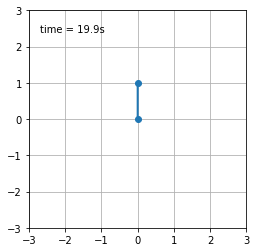

In [22]:
# ball: m = 1 kg
# pole: L = 1 m
# cart: M = 4 kg


import numpy as np

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import max_norm


# TODO should move all this to a module (probably merge with the old cartpole module we were using)

g = 9.81  # m/s^2
L = 1.0  # length of the pole (m)
M = 4.0  # mass of the cart (kg)
m = 1  # mass of the ball at the end of the pole (kg)

rad = np.pi / 180


# control input: u = F
# q is the state vector
def control(q):
    if (q[0] < 140 * rad) or (q[0] > 220 * rad):
        # swing up
        # energy error: Ee
        Ee = 0.5 * m * L * L * q[2] ** 2 - m * g * L * (1 + cos(q[0]))
        # energy control gain:
        k = 0.23
        # input acceleration: A (of cart)
        A = k * Ee * cos(q[0]) * q[2]
        # convert A to u (using EOM)
        delta = m * sin(q[0]) ** 2 + M
        u = A * delta - m * L * (q[2] ** 2) * sin(q[0]) - m * g * sin(q[2]) * cos(q[2])
    else:
        # balancing
        # LQR: K values from MATLAB
        k1 = 140.560
        k2 = -3.162
        k3 = 41.772
        k4 = -8.314
        u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
    return u


# state vector: q = transpose([theta, x, d(theta)/dt, dx/dt])
def derivs(q, t):
    dqdt = np.zeros_like(q)

    # control input
    u = control(q)

    delta = m * sin(q[0]) ** 2 + M

    dqdt[0] = q[2]
    dqdt[1] = q[3]

    dqdt[2] = - m * (q[2] ** 2) * sin(q[0]) * cos(q[0]) / delta \
              - (m + M) * g * sin(q[0]) / delta / L \
              - u * cos(q[0]) / delta / L

    dqdt[3] = m * L * (q[2] ** 2) * sin(q[0]) / delta \
              + m * L * g * sin(q[0]) * cos(q[0]) / delta / L \
              + u / delta

    return dqdt


# time step
dt = 0.1
t = np.arange(0.0, 20, dt)

rad = np.pi / 180


num_trials = 100
num_states = 4
num_t = len(t)
y = np.zeros((num_t, num_states, num_trials))

for i in range(num_trials):
    # initial conditions
    theta = 0
    x = 0.0
    th_dot = 2*(i/num_trials) - 1  # an initial velocity, triggers the swing up control
    xdot = 0.0

    # initial state
    state = np.array([theta, x, th_dot, xdot])

    # integrate the ODE using scipy.integrate.
    y[:, :, i] = integrate.odeint(derivs, state, t)


#animation generation
def animate_pend(y):
    th = y[:,0]
    x1 = y[:,1]
    y1 = 0.0

    x2 = L * sin(th) + x1
    y2 = -L * cos(th) + y1

    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, aspect='equal', \
                     xlim=(-3, 3), ylim=(-3, 3))
    ax.grid()

    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text


    def animate(i):
        thisx = [x1[i], x2[i]]
        thisy = [y1, y2[i]]

        line.set_data(thisx, thisy)
        time_text.set_text(time_template % (i * dt))
        return line, time_text


    return animation.FuncAnimation(fig, animate, np.arange(1, len(y)), interval=40, blit=True, init_func=init)


ani = animate_pend(y[:,:,0])
HTML(ani.to_jshtml())

# show the animation
#ani
#HTML(ani.to_html5_video())

#plt.figure()

#plt.plot(y[:,1,1])
#plt.show()


In [23]:
tol = .1

# This expression just gives all the trials that end up within tol of pi at the final timestep
((pi - tol) < y[-1,0,:]) &  (y[-1,0,:] < (pi + tol))

#control_vec = np.vectorize(control)

u = np.zeros((num_t, num_trials))
for i in range(num_trials):
    for t in range(num_t):
        u[t,i] = control(y[t,:,i]) 

#(-1 < y[-1,0,:]) | (1 < y[-1,0,:])

In [24]:
# create model
# This is the actual 3 layer MLP, find it as "policy" using tensorboard 
with tf.variable_scope('pi/pol/'):

    model = Sequential()
    model.add(Dense(12, input_dim=4, kernel_initializer='normal', activation='relu', name = 'fc1'))
    model.add(Dense(12,   input_dim=12, kernel_initializer='normal', activation='relu', name = 'fc2'))
    #model.add(Dense(32,   input_dim=32, kernel_initializer='normal', activation='relu', name = 'fc3'))
    model.add(Dense(1, kernel_initializer='normal', kernel_constraint=max_norm(10.), name = 'final' ))

# Compile model
# This adds some other stuff to your model that we don't want to consider the policy
model.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
# Create our LSTM network

look_back = 3000

with tf.variable_scope('pi/pol/'):
    model = Sequential()
    model.add(Embedding(1,12,input_length = look_back))
    model.add(LSTM(12, return_sequences = True))
    #model.add(LSTM(4, input_shape =(12,look_back)))
    model.add(TimeDistributed(Dense(1)))

    #model.add(Dense(2))
    

model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
# you can either go ahead and fit the model or load weights, this cell will go ahead and run the fit routine

y_flat = y.reshape((num_t*num_trials,4))
u_flat = u.reshape((num_t*num_trials))

training_input = y_flat
training_output = u_flat
history = model.fit(training_input, training_output, epochs=2000, verbose=0)

'./2000_naive'

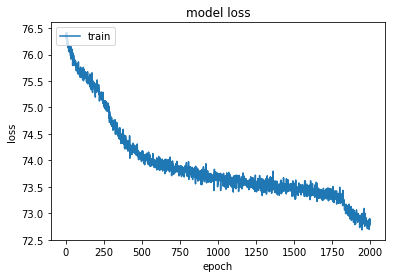

In [35]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


In [36]:
#cart = cps.CartPoleSim("cartpole.xml")

def make_controller(model):
    def nn_controller(q):
       # print(q.shape)
        #return model.predict(np.reshape(np.array([q_pos[1], *q_vel]), (1,3)))[0][0] 
        return model.predict(q.reshape((1,4)))    
    return nn_controller

#cart.num_steps = 1500
control = make_controller(model)

# initial conditions
theta = 0
x = 0.0
th_dot = .01  # an initial velocity, triggers the swing up control
xdot = 0.0
t = np.arange(0.0, 20, dt)


# initial state
state = np.array([theta, x, th_dot, xdot])

# integrate the ODE using scipy.integrate.
y_test = integrate.odeint(derivs, state, t)



#cart.default_state[1][1] = 0
#cart.default_state[1][0] = 0

#cart.run_sim()
#cart.plot_history()

In [37]:
u_test = np.array([control(q) for q in y_test])
u_test

array([[[ 1.0602907 ]],

       [[ 0.17206872]],

       [[ 0.07141709]],

       [[ 0.08597916]],

       [[ 0.12321389]],

       [[ 0.17134619]],

       [[ 0.23009264]],

       [[ 0.30113637]],

       [[ 0.475523  ]],

       [[ 0.6455965 ]],

       [[ 0.8640088 ]],

       [[ 1.1562444 ]],

       [[ 1.5487123 ]],

       [[ 2.1153007 ]],

       [[ 2.990893  ]],

       [[ 4.1035438 ]],

       [[ 5.6341133 ]],

       [[ 7.5826125 ]],

       [[ 9.143314  ]],

       [[ 6.9419537 ]],

       [[ 8.162029  ]],

       [[ 9.537691  ]],

       [[11.637236  ]],

       [[13.916445  ]],

       [[13.102928  ]],

       [[13.150557  ]],

       [[13.373894  ]],

       [[13.452322  ]],

       [[12.995571  ]],

       [[12.30167   ]],

       [[11.309635  ]],

       [[10.398428  ]],

       [[ 9.033968  ]],

       [[ 7.322108  ]],

       [[ 5.3597264 ]],

       [[ 3.225658  ]],

       [[ 1.1873864 ]],

       [[ 1.2714612 ]],

       [[ 1.291718  ]],

       [[ 1.2691323 ]],



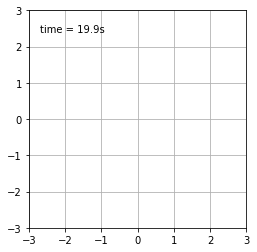

In [38]:
ani = animate_pend(y_test)
HTML(ani.to_jshtml())

In [ ]:
# TODO clean up with mess
pol_vars = tf.trainable_variables('pi/pol/')
saver = tf.train.Saver(pol_vars)
sess = tf.keras.backend.get_session()
saver.save(sess,'./2000_naive')